### LAB: Chest X-Ray Images for Medical Diagnosis

** Objectives: ** Prepare data for Building a Deep Learning model to discriminate between 14 different pathologies from chest X-ray images. 
 In particular, you will:
- Pre-process and prepare a real-world X-ray dataset
- Learn a technique to handle class imbalance



<img src="https://github.com/renanaferreira/CAA-repository/blob/main/Lab4/images/xray-header-image.png?raw=true" style="width:650px;height:200px;">

In [28]:
#import warnings
#warnings.filterwarnings('ignore',category=FutureWarning)
#warnings.filterwarnings('ignore',category=DeprecationWarning)

import os
import numpy as np 
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt  

#high-level interface for drawing attractive and informative 
#statistical graphics
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

from tensorflow.keras.utils import load_img, img_to_array
from keras.models import load_model

# util provides locally defined utility functions required for this lab work.
#import util

random.seed(a=None, version=2)
set_verbosity(INFO)

In [3]:
def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_img(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(1,5,1)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(1,5,1 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

###  1. Load Chest X-ray Images: Data Exploration and Image Preprocessing 

**Objectives**: Become familiar with Chest X-ray data set, that is a small part of the images in the  [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 patients. 

The first step for any Machine Learning (ML) project is to explore the data.

- Each image in the data set contains labels for 14 different pathological conditions, that can be used by physicians to diagnose different diseases. 
- We will use this data to develop a binary classification model to predict 'positive' (pathology is present, label 1) or 'negative' (pathology is not present, label 0) for each of the 14 labeled pathologies. 
- The dataset consists of  422 images stored in folder **nih/images-small/**. 
- The dataset includes 3 CSV (Comma-Separated Values) files with the labels for each X-ray: 

1. `nih/train-small.csv`: training images.
1. `nih/valid-small.csv`: validation images.
1. `nih/test.csv`:testing images . 

#### Several meanings of word  'class'
The word **'class'** is used in multiple ways is this lab. 
- We sometimes refer to each of the 14 pathological conditions that are labeled in our dataset as a class. 
- But for each of those pathologies we are attempting to predict whether a certain condition is present (i.e. positive result) or absent (i.e. negative result). 
    - These two possible labels of 'positive' or 'negative' (or the numerical equivalent of 1 or 0) are also typically referred to as classes. 
- Moreover, we also use the term in reference to software code 'classes' such as `ImageDataGenerator`.

As long as you are aware of all this though, it should not cause you any confusion as the term 'class' is usually clear from the context in which it is used.


In [27]:
# Read the csv file containing training data with pandas library 
train_df = pd.read_csv('/kaggle/input/nih-chest-xray-dataset/train-small.csv')

# Print the first few rows of train_df => dictionary with several keys 
train_df.head()

#What are the keys ?
print(len(train_df.columns))

#What are the dimensions (rows, columns) of train_df and their meaning ? 
print(train_df.shape)

# Do the same for validation and testing data

valid_df = pd.read_csv('/kaggle/input/nih-chest-xray-dataset/valid-small.csv')

valid_df.head()
print(valid_df.columns)
print(valid_df.shape)

test_df = pd.read_csv('/kaggle/input/nih-chest-xray-dataset/test.csv')

test_df.head()
print(test_df.columns)
print(test_df.shape)

16
(1000, 16)
Index(['Image', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'Nodule', 'PatientId', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'],
      dtype='object')
(200, 16)
Index(['Image', 'PatientId', 'Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation'],
      dtype='object')
(420, 16)


In [17]:
# 14 pathological conditions 

labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']


### Explore data labels
The csv file has 16 columns: "Image" column with the names of the chest x-ray images, "PatientId" column with the patient ID and 14 other (binary) columns filled with 1 or 0 to identify if the pathology is present (1) or not (0) in this x-ray image.
 

In [24]:
#Compute the # of positive labels (1's) for each condition (pathology).

for label in labels:
    count = len(train_df.loc[train_df[label] == 1])
    print(f"{label}: {count}")

Cardiomegaly: 20
Emphysema: 13
Effusion: 128
Hernia: 2
Infiltration: 175
Mass: 45
Nodule: 54
Atelectasis: 106
Pneumothorax: 38
Pleural_Thickening: 21
Pneumonia: 10
Fibrosis: 14
Edema: 16
Consolidation: 33


You are supposed to see that data is highly unbalanced. 

### 2. Data Visualization - Display some images

In [25]:
imag = []
imag.append('00008270_015.png')
imag.append('00000116_034.png')
imag.append("00000359_010.png")
imag.append("00000121_008.png")
imag.append('00000003_001.png')


Display some images


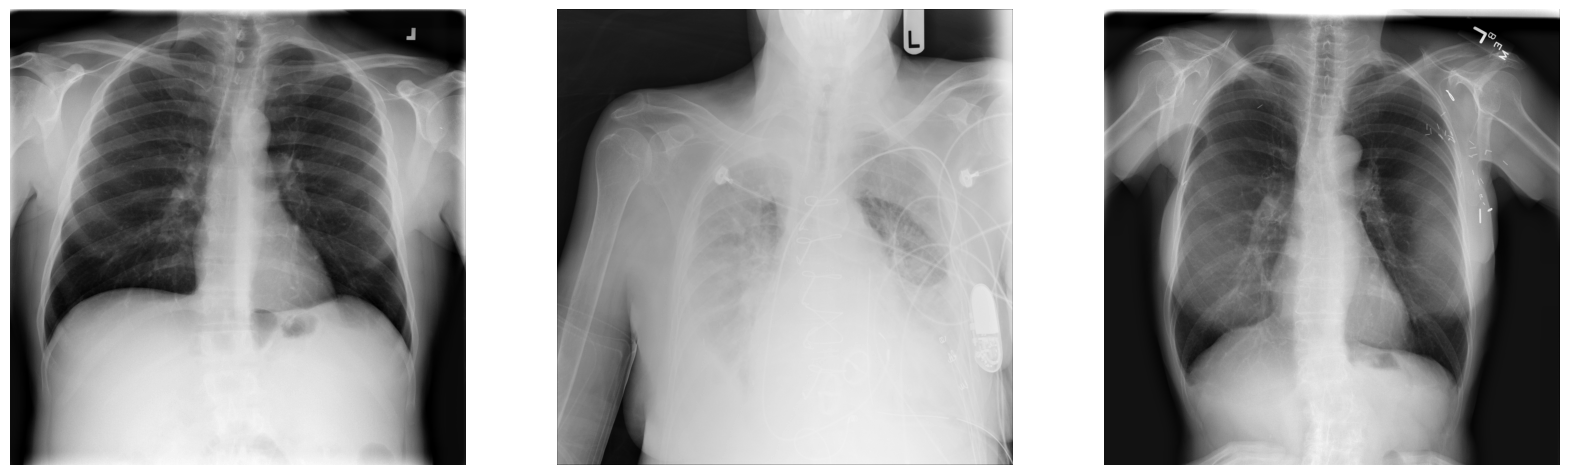

In [26]:
# Location of the image directory
IMAGE_DIR = "/kaggle/input/nih-chest-xray-dataset/Images zip/Images zip/images-small/"

print('Display some images')

# Adjust the size of the images
plt.figure(figsize=(20,10))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    img = plt.imread(os.path.join(IMAGE_DIR, imag[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

### Investigate a single image


In [29]:
# Choose the first image from imag
sample_img = imag[0]

img = img_to_array(load_img(os.path.join(IMAGE_DIR, sample_img),color_mode="grayscale"))

#  Image dimension ? 
#Answer: 1024 px width, 1024 px height, 1 color (gray) channel

print(img.shape)

# Pixel max, min, mean values, standard deviation 
print(np.amax(img))
print(np.amin(img))
print(np.mean(img))
print(np.std(img))

(1024, 1024, 1)
250.0
0.0
122.3016
70.31242


### Investigate pixel value distribution
Plot the distribution of pixel values in the image you selected above. 

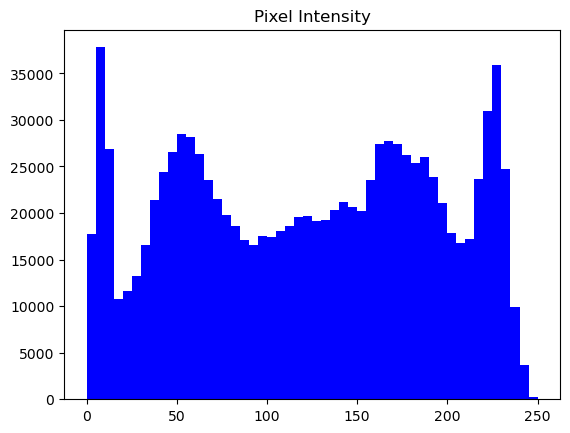

In [30]:
# histogram
plt.hist(img.ravel(),bins=50, color="blue")
plt.title("Pixel Intensity")
plt.show()

###  3. Preparing Images

- We will use now [ImageDataGenerator](https://keras.io/preprocessing/image/) class from Keras framework, which allows to build a "generator" for images specified in a dataframe. 
- This class also provides support for basic data augmentation such as random horizontal flipping of images.
- We also use the generator to normalize the values in each batch (train, validate, test sets) so that their mean is $0$ and their standard deviation is 1. In other words, the generator will replace each pixel value in the image with a new value calculated by subtracting the mean and dividing by the standard deviation.  This will facilitate model training by standardizing the input distribution. 

$$\frac{x_i - \mu}{\sigma}$$

- The generator also converts a single channel X-ray images (gray-scale) to a 3-channel format by repeating the values in the image across all channels, because the pre-trained model that we'll use requires 3-channel inputs.

The implemented generator below will
1. Normalize the mean and standard deviation of the data
3. Shuffle the input after each epoch.
4. Set the image size to be 320px by 320px

In [31]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, 
    batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    """
    Return generator for training set, normalizing using batch statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): that transforms the entire training set
    """        
    print("Train images:")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

Now we build a new generator to transform (normalize) the validation and testing data. 
We can't use the same generator as for the training data because the test data has to be normalized using the statistics computed from the training set. 

In [32]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir,
    x_col, y_cols, sample_size=100, batch_size=8, seed=1, 
    target_w = 320, target_h = 320):
    
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization 
      statistics.
      batch_size (int): images per batch to be fed into model during 
      training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: 
        iterators over test set and validation set respectively
    """
     # Generator of train images
    print("Train images:")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample (1 image) 
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use 1 sample (1 image) to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # Generator of validation images
    print("Validation images:")
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    # Generator of test images
    print("Test images:")
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

Apply the generator function to preprocess the training, validation and test data

**Note:** The train_df csv file has a list of 1000 images, however in the directory we only have 296 training images, therefore it prints a warning message. and validation datasets.

In [33]:
# Call the generators to prepare the training, validation and test data
x_col = "Image"
train_generator = get_train_generator(train_df, IMAGE_DIR, x_col, labels)

valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, x_col, labels)

Train images:
Found 1000 validated image filenames.
Train images:
Found 1000 validated image filenames.
Validation images:
Found 200 validated image filenames.
Test images:
Found 420 validated image filenames.


Let's see what the generator gives to the model by `__getitem__(index)` function and compare with the original image:

In [34]:
generated_image, label = train_generator.__getitem__(0)

# What is the shape of the generated_image ? 
print(generated_image.shape)
# What is the meaning of each dimension ?

# What is the pixel values range (max, min) of the normalized images ?
print(np.amax(generated_image))
print(np.amin(generated_image))

# What is the Mean pixel value and the standard deviation ?
print(np.mean(generated_image))
print(np.std(generated_image))



(8, 320, 320, 3)
2.8193502
-3.4863174
2.4239222e-08
1.0000001


Text(0.5, 1.0, 'Normalized chest X-ray image')

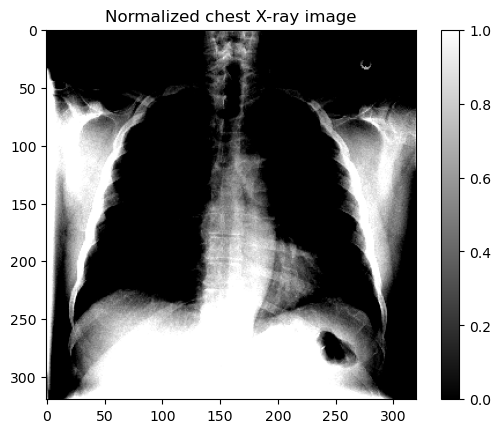

In [35]:
# Plot the first image from generated_image (normalized image)
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap="gray")
plt.colorbar()
plt.title("Normalized chest X-ray image")

In [ ]:
# Plot the first image from imag (original image)
?

Plot the histograms of the original and the normalized images and get a similar figure.

<img src="https://github.com/renanaferreira/CAA-repository/blob/main/Lab4/images/f1.png?raw=true" style="width:300px;height:200px;">


In [ ]:
# histogram of the distribution of the pixels
?

### 4. Addressing Class Imbalance
One of the challenges with medical datasets is the large class imbalance. Let's plot the frequency of each of the labels in our dataset:

In [ ]:
# Plot the class frequency
plt.xticks(rotation=90)

sns.barplot(labels, np.mean(train_generator.labels, axis=0), color='b')
#sns.barplot(np.mean(train_generator.labels, axis=0), labels, color='b')
plt.title("Frequency of Each Class", fontsize=10)
plt.ylabel('Pathology', fontsize=10)
plt.show()

# What is the dimension and the meaning of train_generator.labels ?

?

We can see from this plot that the presence of different pathologies (classes) varies significantly. (The same trend happens in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* Even the `Infiltration` pathology, has about 15.5% of the training cases labelled positive.

If we use a normal cross-entropy loss function with this highly unbalanced dataset, the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss. 

#### Impact of class imbalance on loss function

 We will use a cross-entropy loss for each pathology. The normal cross-entropy loss from the $i^{th}$ training example is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ are the input features and $y_i$ is the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive (1) or negative (0). 

For any training case, either $y_i=0$ or $y_i=1$ , so only one term contributes to the loss (the other term is multiplied by zero). 

The average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ is as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

We can see that if there is a large imbalance with very few positive training cases, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$


### Computing Class Frequencies
Complete the function below to calculate these frequences for each label in the dataset.

Use numpy.sum(a, axis= ?), and choose the axis (0 or 1) </li>

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, 
        num_classes)
        
    Returns:
positive_frequencies (np.array): array of positive frequences for each
                                class, size (num_classes)
negative_frequencies (np.array): array of negative frequences for each
                                class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = ?
    
    positive_frequencies = ?
    negative_frequencies = ?

    return positive_frequencies, negative_frequencies

Compute the frequencies for our training data.

In [ ]:
freq_pos, freq_neg = ?



Let's visualize these two contribution ratios next to each other for each of the pathologies:

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": 
                     freq_pos})

data = data.append([{"Class": labels[l], "Label": "Negative", "Value": 
    v} for l,v in enumerate(freq_neg)], ignore_index=True)

plt.xticks(rotation=90)

f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 


$$pos\_contribution=w_{pos} \times freq_{p} = w_{neg} \times freq_{n} =neg\_contribution$$

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [ ]:
pos_w = ?
neg_w = ?
pos_contribution = ?
neg_contribution = ?

Verify that now the contribution of the positive and negative labels is equal. It is expected to get a similar plot as the one below. 

<img src="images/f_bal_contr.png" style="width:300px;height:250px;">

In [ ]:


f = ?

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. 
After computing the weights, the final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

### Computing the Weighted Loss
The function below computes the average weighted loss for all training examples (batch data). For the multi-class loss, the average loss for each individual class is computed. The small value, $\epsilon$, is added to the predicted values before taking their logs. This is to avoid a numerical error that would otherwise occur if the predicted value happens to be zero.


In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and 
    positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
      epsilon: to avoid numerical errors if the predicted value = 0.
    
Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

Args:
 y_true (Tensor): Tensor of true labels, size is 
 (num_examples, num_classes)
 y_pred (Tensor): Tensor of predicted labels, size is (num_examples, 
 num_classes)
 
Returns:
    loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
# for each class, add average weighted loss for that class
#K.mean, K.log are Keras functions to calculate the mean and the log.
            
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            
            loss += loss_pos + loss_neg 
        return loss
    
    return weighted_loss